# eDisGo basic emobility example

This example shows you the first steps how to integrate electromobility into eDisGo.

### Learn more about eDisGo

* __[eDisGo Source Code](https://github.com/openego/eDisGo)__
* __[eDisGo Documentation](http://edisgo.readthedocs.io/en/dev/)__

### Table of Contents


* [Installation](#installation)
* [Settings](#settings)
* [eDisGo add electromobility](#emob)
* [eDisGo electromobility data structure](#network)

## Installation <a class="anchor" id="installation"></a>

This notebook requires a working installation of eDisGo as well as `jupyter notebook` to run the example and `contextily` to view the grid topology on a map. You can install all of these as follows:

```python
pip install eDisGo[examples,geoplot]
```

Checkout the eDisGo documentation on [how to install eDisGo](https://edisgo.readthedocs.io/en/dev/quickstart.html#getting-started) for more information.

#### Import packages

In [49]:
import requests
import pandas as pd

from pathlib import Path

from edisgo.edisgo import import_edisgo_from_files
from edisgo.tools.tools import select_worstcase_snapshots

### Settings <a class="anchor" id="settings"></a>

The class **EDisGo** serves as the top-level API for
setting up your scenario, invocation of data import, power flow analysis, grid reinforcement and flexibility measures. It also provides access to all relevant data. See the [class documentation](http://edisgo.readthedocs.io/en/dev/api/edisgo.grid.html#edisgo.grid.network.EDisGo) for more information.

To set up a scenario to do a worst-case analysis that considers the heavy load flow and reverse power flow cases used in distribution grid planning, you simply have to provide a grid and call the function`set_time_series_worst_case_analysis`, which is both explained in the following two sections. 

#### Distribution grid data

Currently, synthetic grid data generated with the python project
[ding0](https://github.com/openego/ding0)
is the only supported data source for distribution grid data. ding0 provides the grid topology data in the form of csv files, with separate files for buses, lines, loads, generators, etc. You can retrieve ding0 data from
[Zenodo](https://zenodo.org/record/890479)
(make sure you choose latest data) or check out the
[Ding0 documentation](https://dingo.readthedocs.io/en/dev/usage_details.html#ding0-examples)
on how to generate grids yourself. A ding0 example grid can be viewed [here](https://github.com/openego/eDisGo/tree/dev/tests/data/ding0_test_network_2). It is possible to provide your own grid data if it is in the same format as the ding0 grid data. 

This example works with any ding0 grid data. If you don't have grid data yet, you can execute the following to download the example grid data mentioned above.

In [2]:
def download_ding0_example_grid_3():
    ding0_example_grid_path = Path().home() / ".edisgo" / "ding0_test_network_3"

    sub_dirs = ["timeseries", "topology"]

    file_names = {
        "timeseries": [
            "generators_active_power",
            "generators_reactive_power",
            "loads_active_power",
            "loads_reactive_power",
        ],
        "topology": [
            "buses",
            "generators",
            "lines",
            "loads",
            "network",
            "switches",
            "transformers",
            "transformers_hvmv",
        ]
    }

    for sub_dir in sub_dirs:
        data_path = ding0_example_grid_path / sub_dir

        data_path.mkdir(parents=True, exist_ok=True)

        for f in file_names[sub_dir]:
            req = requests.get(
                "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
                f"ding0_test_network_3/{sub_dir}/{f}.csv"
            )

            file_path = data_path / f"{f}.csv"

            with open(file_path, "wb") as fout:
                fout.write(req.content)
                
    return ding0_example_grid_path

ding0_example_grid_path = download_ding0_example_grid_3()

Now we are ready to initialize the edisgo object and conducts a static, non-linear power flow analysis for the worst case time steps.

In [56]:
edisgo = import_edisgo_from_files(ding0_example_grid_path, import_timeseries=True)

In [57]:
worst_case_timesteps = select_worstcase_snapshots(edisgo)
worst_case_timesteps = pd.DatetimeIndex([worst_case_timesteps['min_residual_load'],
                                         worst_case_timesteps['max_residual_load']])
edisgo.analyze(timesteps=worst_case_timesteps)

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.171997 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.234916 seconds


DatetimeIndex([], dtype='datetime64[ns]', name='snapshot', freq=None)

In [59]:
edisgo.reinforce(timesteps_pfa=worst_case_timesteps)

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.174519 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.215528 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.161327 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.178948 seconds
INFO:edisgo.flex_opt.reinforce_grid:==> Load issues were solved in 1 iteration step(s).
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:0

### eDisGo add electromobility <a class="anchor" id="emob"></a>

#### Electromobility data
So far, adding electormobility data to an eDisGo object requires electromobility data from SimBEV (required version: 3083c5a) and TracBEV (required version: 14d864c) to be stored in the directories specified through the parameters simbev_directory and tracbev_directory. SimBEV provides data on standing times, charging demand, etc. per vehicle, whereas TracBEV provides potential charging point locations.

If you don't have simBEV and tracBEV data yet, you can execute the following to download the example data for the ding0 grid downloaded above.

In [77]:
def download_simBEV_tracBEV_data():
    simBEV_tracBEV_path = Path().home() / ".edisgo"

    sub_dirs = ["simbev_example_scenario/simbev_run/09184119", "tracbev_example_scenario"]

    file_names = {
        "simbev_example_scenario/simbev_run/09184119": [
            "bev_luxury_00000_90kWh_LR_Zentr_events",
            "bev_medium_00000_65kWh_LR_Zentr_events",
            "bev_medium_00001_65kWh_LR_Zentr_events",
            "bev_medium_00002_65kWh_LR_Zentr_events",
            "bev_mini_00000_30kWh_LR_Zentr_events",
            "bev_mini_00001_30kWh_LR_Zentr_events",
            "phev_luxury_00000_20kWh_LR_Zentr_events",
            "phev_medium_00000_20kWh_LR_Zentr_events",
            "phev_medium_00001_20kWh_LR_Zentr_events",
            "phev_mini_00000_20kWh_LR_Zentr_events",
        ],
        "tracbev_example_scenario": [
            "output_home_09184119",
            "output_hpc_09184119",
            "output_public_09184119",
            "output_work_09184119",
        ]
    }

    for sub_dir in sub_dirs:
        data_path = simBEV_tracBEV_path / sub_dir

        data_path.mkdir(parents=True, exist_ok=True)

        for f in file_names[sub_dir]:
            req = requests.get(
                "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
                f"{sub_dir}/{f}.csv"
            )

            file_path = data_path / f"{f}.csv"

            with open(file_path, "wb") as fout:
                fout.write(req.content)
                
            if sub_dir == "tracbev_example_scenario":
                req = requests.get(
                    "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
                    f"{sub_dir}/{f}.gpkg"
                )

                file_path = data_path / f"{f}.gpkg"

                with open(file_path, "wb") as fout:
                    fout.write(req.content)

    data_path = simBEV_tracBEV_path / "simbev_example_scenario"
    req = requests.get(
                "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
                "simbev_example_scenario/metadata_simbev_run.json"
            )

    file_path = data_path / "metadata_simbev_run.json"

    with open(file_path, "wb") as fout:
        fout.write(req.content)
                
download_simBEV_tracBEV_data()

In order to integrate the electromobility data of the grid that you downloaded above, you can use the following function:

In [78]:
edisgo.import_electromobility(simbev_directory= Path().home() / ".edisgo/simbev_example_scenario",
                             tracbev_directory= Path().home() / ".edisgo/tracbev_example_scenario")

INFO:fiona.ogrext:Failed to auto identify EPSG: 7
/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects

### eDisGo electromobility data structure <a class="anchor" id="network"></a>

The EDisGo class serves as the top-level API and provides access to all relevant data.

Grid data is stored in the [Topology](https://edisgo.readthedocs.io/en/dev/api/edisgo.network.html#edisgo.network.topology.Topology) class.
Time series data can be found in the [TimeSeries](https://edisgo.readthedocs.io/en/dev/api/edisgo.network.html#edisgo.network.timeseries.TimeSeries) class. Results data holding results e.g. from the power flow analysis and grid expansion is stored in the [Results](https://edisgo.readthedocs.io/en/dev/api/edisgo.network.html#edisgo.network.results.Results) class.
Configuration data from the config files (see [default_configs](https://edisgo.readthedocs.io/en/dev/configs.html#default-configuration-data)) is stored
in the [Config](https://edisgo.readthedocs.io/en/dev/api/edisgo.tools.html#edisgo.tools.config.Config) class.
All these can be accessed as follows:

```python
edisgo.topology
edisgo.timeseries
edisgo.results
edisgo.config
```

The electromobility data in the Topology object is stored in a pandas DataFrame and can be accessed as follows:

In [79]:
edisgo.topology.charging_points_df.head()

,bus,p_set,annual_consumption,sector,type,p,mvlv_subst_id,geom,voltage_level
Charging_Point_LVGrid_20543_home_1,BranchTee_mvgd_2534_lvgd_20543_202,0.0122,NaN,home,charging_point,0.0122,20543.0,POINT (11.60644729360077 48.248289543410564),7.0
Charging_Point_LVGrid_20564_home_1,BranchTee_mvgd_2534_lvgd_20564_106,0.0122,NaN,home,charging_point,0.0122,20564.0,POINT (11.645411334679864 48.245916092717714),7.0
Charging_Point_LVGrid_20572_home_1,BranchTee_mvgd_2534_lvgd_20572_106,0.0122,NaN,home,charging_point,0.0122,20572.0,POINT (11.654771276522016 48.243976403882435),7.0
Charging_Point_LVGrid_20579_home_1,BranchTee_mvgd_2534_lvgd_20579_106,0.0122,NaN,home,charging_point,0.0122,20579.0,POINT (11.657698017825746 48.25113187539169),7.0
Charging_Point_LVGrid_20565_home_1,BranchTee_mvgd_2534_lvgd_20565_106,0.0122,NaN,home,charging_point,0.0122,20565.0,POINT (11.642807867380885 48.24865460210316),7.0


Be aware that the import_electromobility() function does not yield charging time series per charging point but only charging processes. The actual charging time series are determined through applying a charging strategy using the function charging_strategy.

The charging processes can be accessed through the edisgo.network.electromobility module as follows:

In [67]:
edisgo.electromobility.charging_processes_df.head()

,ags,car_id,destination,use_case,nominal_charging_capacity_kW,grid_charging_capacity_kW,chargingdemand_kWh,park_time_timesteps,park_start_timesteps,park_end_timesteps,charging_park_id,charging_point_id
0,9184119,0,4_private/ridesharing,public,50.0,55.5556,25.0000,2,63,64,257,11
1,9184119,0,0_work,work,22.0,24.4444,16.4184,22,223,244,426,0
2,9184119,0,0_work,work,22.0,24.4444,8.4318,39,511,549,426,0
3,9184119,0,7_charging_hub,hpc,150.0,166.6667,37.5000,1,562,563,164,10
4,9184119,0,7_charging_hub,hpc,150.0,166.6667,37.5000,1,570,571,164,10


In order to obtain charging time series, a charging strategy to set EV charging time series at charging parks has to be applied using the following function:

INFO:root:Charging strategy dumb completed.
/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



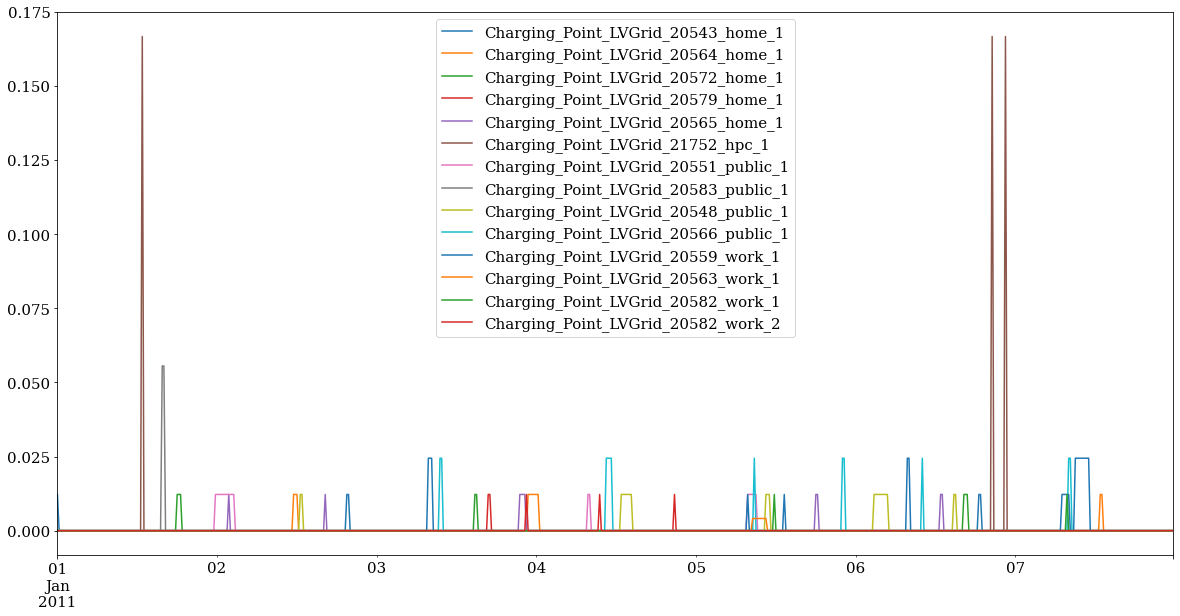

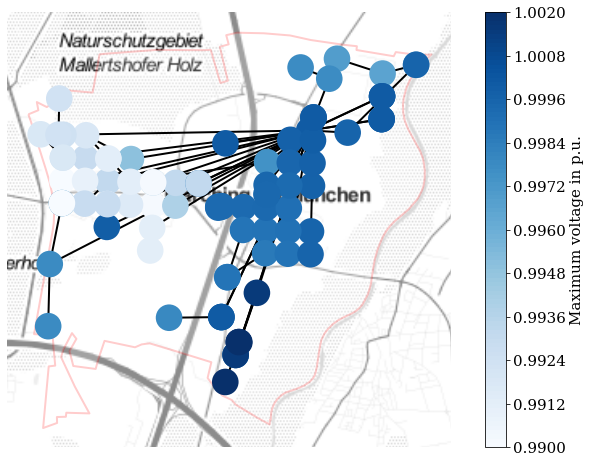

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



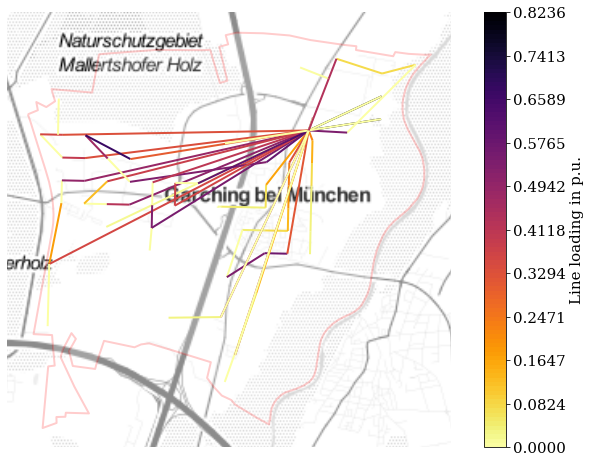

In [74]:
edisgo.apply_charging_strategy()
edisgo.timeseries.charging_points_active_power(edisgo).plot(figsize=(20,10))
edisgo.plot_mv_voltages()
edisgo.plot_mv_line_loading()

The default charging strategy is 'dumb', which means that the cars are charged directly after arrival with the maximum possible charging capacity. 

Further strategies are:

* ’reduced’

The cars are charged directly after arrival with the minimum possible charging power. The minimum possible charging power is determined by the parking time and the parameter minimum_charging_capacity_factor.

* ’residual’

The cars are charged when the residual load in the MV grid is lowest (high generation and low consumption). Charging processes with a low flexibility are given priority.


To change the charging strategy to one of the latter strategies, the 'strategy' parameter has to be set accordingly:

INFO:root:Charging strategy reduced completed.
/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



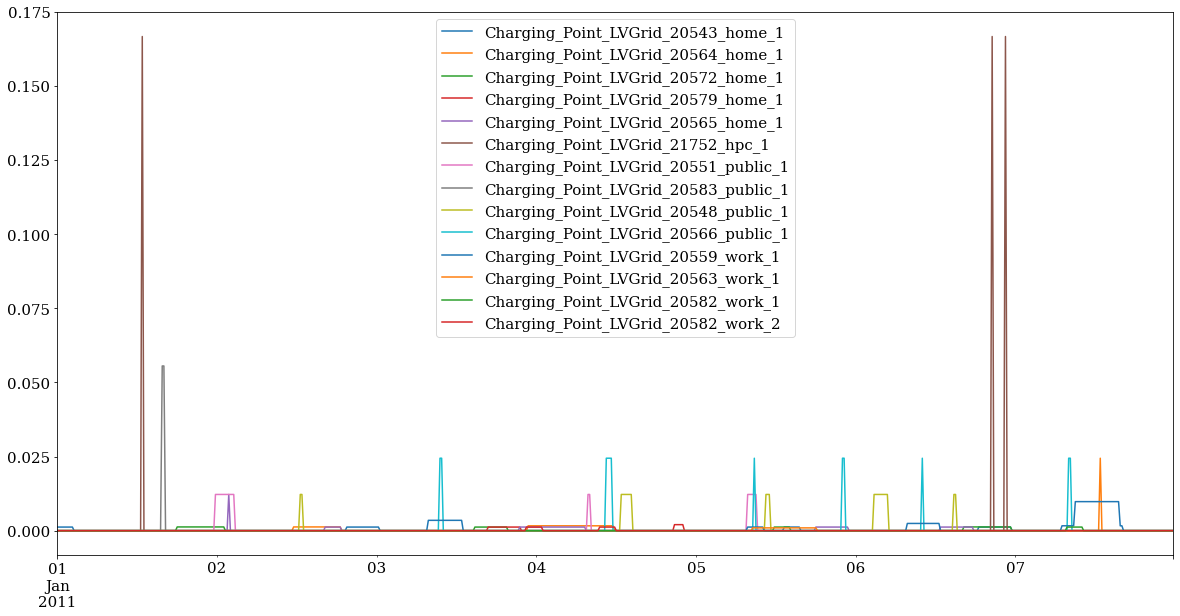

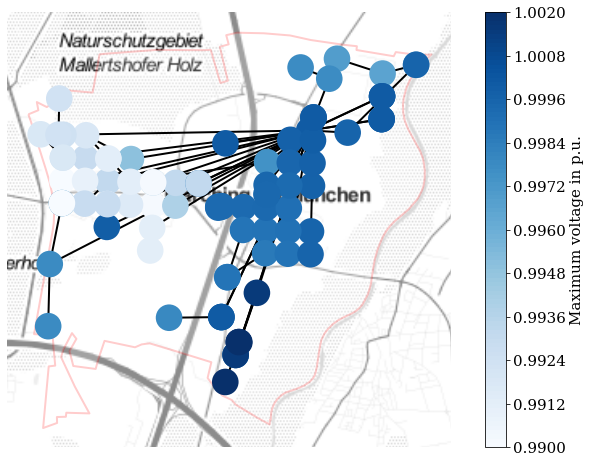

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



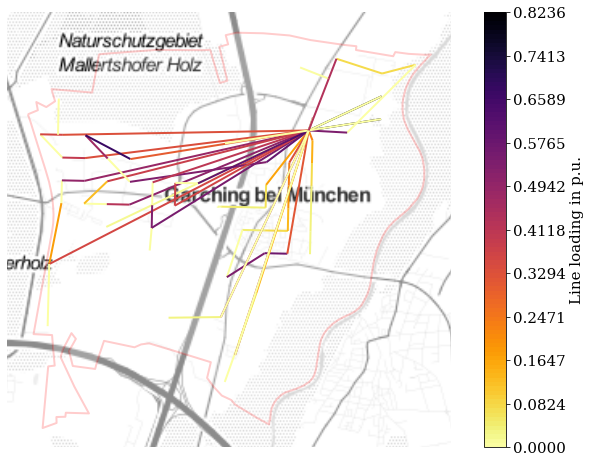

In [75]:
edisgo.apply_charging_strategy(strategy='reduced')
edisgo.timeseries.charging_points_active_power(edisgo).plot(figsize=(20,10))
edisgo.plot_mv_voltages()
edisgo.plot_mv_line_loading()

INFO:root:Charging strategy residual completed.
/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



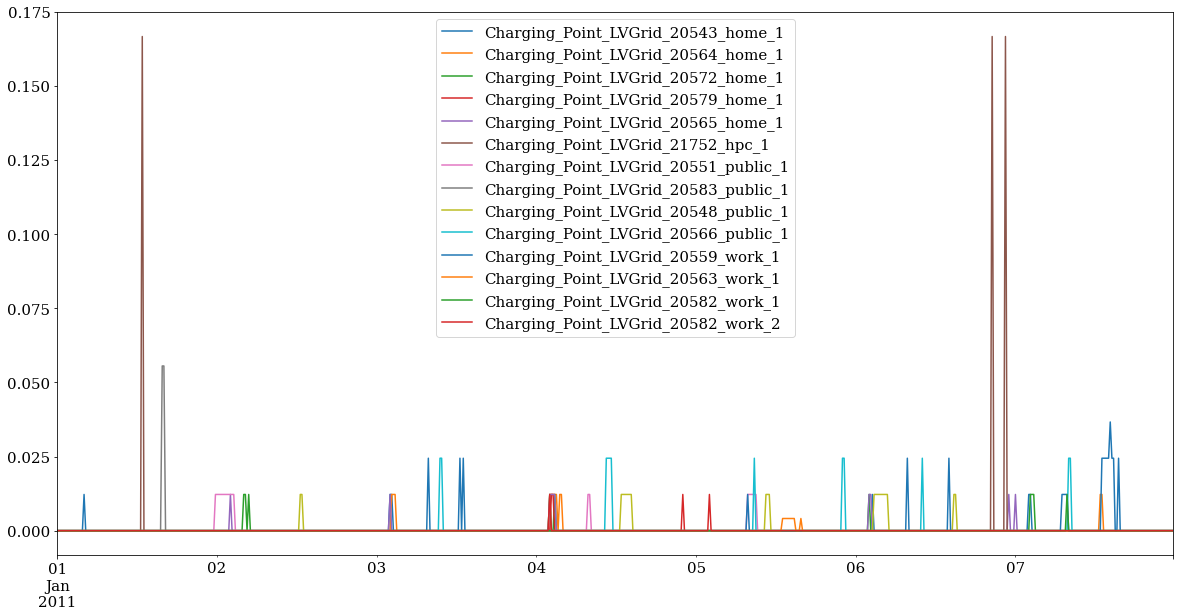

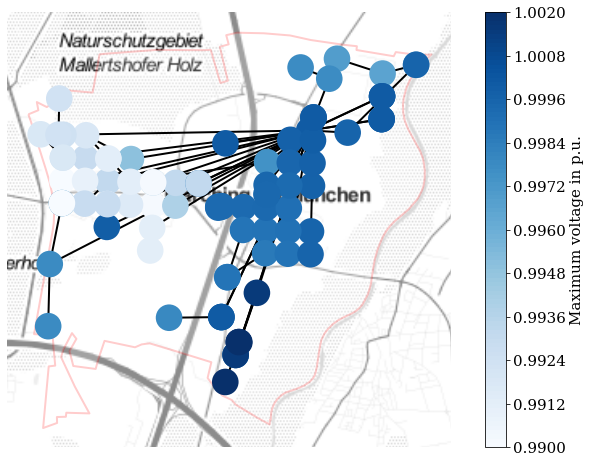

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/local/RL-INSTITUT/maike.held/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



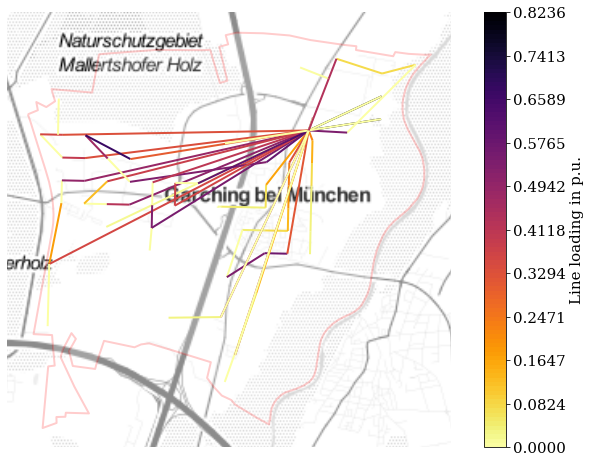

In [76]:
edisgo.apply_charging_strategy(strategy='residual')
edisgo.timeseries.charging_points_active_power(edisgo).plot(figsize=(20,10))
edisgo.plot_mv_voltages()
edisgo.plot_mv_line_loading()